# **Visualization of rents in newly constructed buildings**

`Rent prices of newly constructed building by region, investors, size of dwelling, observations and year.`

`Data source: SCB (Statistics Sweden)`

- Location : Greater Stockholm, Greater Gothenburg, Greater Malmö, Municipalities with > 75000 inhabitants (excluding metropolitan areas), Municipalities with < 75000 inhabitants (excluding metropolitan areas)
Developer: public or private
- Apartment type
- Living space per apartment
- Annual rent per sqm
- Annual rent per apartment
- Monthly rent
- Year

In [1]:
# step 1:  Importing all required libraries
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
import joypy as jp
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RSEED = 8

## **`Step 1: Loading the data.`**

In [2]:
# reading the csv file with house rent details of Sweden
dataset = pd.read_csv("SCB_house_Rent_Sweden.csv", sep=";", header=0, skipinitialspace = True)

In [3]:
dataset.head()

,region,developer,apartment type,"Apartments, number of apartments on which the price statistics are based","Living space per apartment, sqm","Annual rent per square meter, SEK","Annual rent per apartment, SEK","Monthly rent (annual rent / 12) per apartment, SEK",Year
0,0010 Greater Stockholm,public,1 room and kitchenette,..,..,..,..,..,2020
1,0010 Greater Stockholm,public,1 room and kitchen,190,35,2659,91964,7664,2020
2,0010 Greater Stockholm,public,2 room and kitchen,299,52,2273,117476,9790,2020
3,0010 Greater Stockholm,public,3 room and kitchen,148,73,2008,146622,12218,2020
4,0010 Greater Stockholm,public,4 room and kitchen,87,90,1898,170467,14206,2020


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype 
---  ------                                                                    --------------  ----- 
 0   region                                                                    560 non-null    object
 1   developer                                                                 560 non-null    object
 2   apartment type                                                            560 non-null    object
 3   Apartments, number of apartments on which the price statistics are based  560 non-null    object
 4   Living space per apartment, sqm                                           560 non-null    object
 5   Annual rent per square meter, SEK                                         560 non-null    object
 6   Annual rent per apartment, SEK                                            5

## **`Step 2: Data Preprocessing starts here.`**

### **2a: Data Imputation**

In [5]:
(dataset == "..").sum()

region                                                                        0
developer                                                                     0
apartment type                                                                0
Apartments, number of apartments on which the price statistics are based    201
Living space per apartment, sqm                                             201
Annual rent per square meter, SEK                                           201
Annual rent per apartment, SEK                                              201
Monthly rent (annual rent / 12) per apartment, SEK                          201
Year                                                                          0
dtype: int64

In [6]:
# Data imputation --> added value 0 for missing values
dataset.replace(to_replace = '..', value = 0, inplace = True)
data_imputed = pd.DataFrame(dataset)

In [7]:
(dataset == "..").sum()

region                                                                      0
developer                                                                   0
apartment type                                                              0
Apartments, number of apartments on which the price statistics are based    0
Living space per apartment, sqm                                             0
Annual rent per square meter, SEK                                           0
Annual rent per apartment, SEK                                              0
Monthly rent (annual rent / 12) per apartment, SEK                          0
Year                                                                        0
dtype: int64

In [8]:
dataset.head()

,region,developer,apartment type,"Apartments, number of apartments on which the price statistics are based","Living space per apartment, sqm","Annual rent per square meter, SEK","Annual rent per apartment, SEK","Monthly rent (annual rent / 12) per apartment, SEK",Year
0,0010 Greater Stockholm,public,1 room and kitchenette,0,0,0,0,0,2020
1,0010 Greater Stockholm,public,1 room and kitchen,190,35,2659,91964,7664,2020
2,0010 Greater Stockholm,public,2 room and kitchen,299,52,2273,117476,9790,2020
3,0010 Greater Stockholm,public,3 room and kitchen,148,73,2008,146622,12218,2020
4,0010 Greater Stockholm,public,4 room and kitchen,87,90,1898,170467,14206,2020


In [9]:
((data_imputed.shape),(type(data_imputed)))

((560, 9), pandas.core.frame.DataFrame)

In [10]:
data_imputed.head()

,region,developer,apartment type,"Apartments, number of apartments on which the price statistics are based","Living space per apartment, sqm","Annual rent per square meter, SEK","Annual rent per apartment, SEK","Monthly rent (annual rent / 12) per apartment, SEK",Year
0,0010 Greater Stockholm,public,1 room and kitchenette,0,0,0,0,0,2020
1,0010 Greater Stockholm,public,1 room and kitchen,190,35,2659,91964,7664,2020
2,0010 Greater Stockholm,public,2 room and kitchen,299,52,2273,117476,9790,2020
3,0010 Greater Stockholm,public,3 room and kitchen,148,73,2008,146622,12218,2020
4,0010 Greater Stockholm,public,4 room and kitchen,87,90,1898,170467,14206,2020


### **2b: Renaming the column names**

In [11]:
# Rename the columns
data_imputed.rename(columns = {'region':'location', 
                               'Apartments, number of apartments on which the price statistics are based':'dwellings',
                              'Living space per apartment, sqm':'living space/apartment',
                              'Annual rent per square meter, SEK' : 'annual rent/sqm',
                              'Annual rent per apartment, SEK' : 'annual rent/apartment',
                              'Monthly rent (annual rent / 12) per apartment, SEK' : 'monthly rent',
                              'Year': 'year'}, inplace = True)

In [12]:
data_imputed.columns

Index(['location', 'developer', 'apartment type', 'dwellings',
       'living space/apartment', 'annual rent/sqm', 'annual rent/apartment',
       'monthly rent', 'year'],
      dtype='object')

### **2c: Redefining the column values**

In [13]:
# Change the values of 'location' column 
data_imputed.replace(to_replace ="0010 Greater  Stockholm", value ="Greater Stockholm", inplace= True)
data_imputed.replace(to_replace ="0020 Greater  Göteborg", value ="Greater Göteborg", inplace= True)
data_imputed.replace(to_replace ="0030 Greater  Malmö", value ="Greater Malmö", inplace= True)
data_imputed.replace(to_replace ="0040 Municipalities with > 75000 inhabitants (excl. Metropolitan areas)", value ="Municipalities with > 75000 inhabitants", inplace= True)
data_imputed.replace(to_replace ="0041 Municipalities with < 75000 inhabitants (excl. Metropolitan areas)", value ="Municipalities with < 75000 inhabitants", inplace= True)


In [14]:
# Change the values of 'developer' column 
data_imputed.replace(to_replace ="private companies and organizations", value ="private", inplace= True)

In [15]:
# Change the values of 'apartment type' column 
data_imputed.replace(to_replace ="1 room and kitchenette", value ="1RKN", inplace= True)
data_imputed.replace(to_replace ="1 room and kitchen", value ="1RK", inplace= True)
data_imputed.replace(to_replace ="2 room and kitchen", value ="2RK", inplace= True)
data_imputed.replace(to_replace ="3 room and kitchen", value ="3RK", inplace= True)
data_imputed.replace(to_replace ="4 room and kitchen", value ="4RK", inplace= True)
data_imputed.replace(to_replace ="5 room and kitchen", value ="5RK", inplace= True)
data_imputed.replace(to_replace ="6 or more rooms and kitchen", value ="6RK", inplace= True)

In [16]:
data_imputed.head(5)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year
0,Greater Stockholm,public,1RKN,0,0,0,0,0,2020
1,Greater Stockholm,public,1RK,190,35,2659,91964,7664,2020
2,Greater Stockholm,public,2RK,299,52,2273,117476,9790,2020
3,Greater Stockholm,public,3RK,148,73,2008,146622,12218,2020
4,Greater Stockholm,public,4RK,87,90,1898,170467,14206,2020


In [17]:
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   location                560 non-null    object
 1   developer               560 non-null    object
 2   apartment type          560 non-null    object
 3   dwellings               560 non-null    object
 4   living space/apartment  560 non-null    object
 5   annual rent/sqm         560 non-null    object
 6   annual rent/apartment   560 non-null    object
 7   monthly rent            560 non-null    object
 8   year                    560 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 39.5+ KB


### **2d: Replacing the values of rows with '0' dwellings**

In [18]:
data_copy = pd.DataFrame(data_imputed.copy(deep=True)) 
columns = list(data_imputed.columns)
columns.pop()      
columns.pop(0)      
columns.pop(1)       
columns.pop(0)      

df_part = data_copy[columns].copy(deep=True)
df_nan = df_part.replace(0,np.nan)
imputer = SimpleImputer(missing_values=0, strategy='mean', copy=False)
imputer.fit(df_part)
df_imputed = imputer.transform(df_part)
imputer.fit(df_part)
df_imputed = imputer.transform(df_part)
df_converted = pd.DataFrame(df_imputed,columns=columns)
data_imputed.loc[:, columns] = df_imputed

In [19]:
((data_imputed.shape),(type(data_imputed)))

((560, 9), pandas.core.frame.DataFrame)

In [20]:
data_imputed.head(5)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year
0,Greater Stockholm,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898.930362,2020
1,Greater Stockholm,public,1RK,190.00000,35.000000,2659.000000,91964.00000,7664.000000,2020
2,Greater Stockholm,public,2RK,299.00000,52.000000,2273.000000,117476.00000,9790.000000,2020
3,Greater Stockholm,public,3RK,148.00000,73.000000,2008.000000,146622.00000,12218.000000,2020
4,Greater Stockholm,public,4RK,87.00000,90.000000,1898.000000,170467.00000,14206.000000,2020


### **2e: Defining a new Class Label column.**

In [21]:
# Inserting a new column to define the class label
data_imputed.insert(9,"class label",0)

In [22]:
data_imputed["monthly rent"] = data_imputed["monthly rent"].astype('int64')
data_imputed["class label"] = data_imputed["class label"].astype(str)
rent = data_imputed["monthly rent"]
label = data_imputed["class label"]

conditions = [
    (data_imputed['monthly rent'] < 8000),
    (data_imputed['monthly rent'] >= 8000) & (data_imputed['monthly rent'] < 16000),
    (data_imputed['monthly rent'] >= 16000)
]
values = ['Low', 'Medium', 'High']
data_imputed['class label'] = np.select(conditions, values)

In [23]:
data_imputed.head(5)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
0,Greater Stockholm,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
1,Greater Stockholm,public,1RK,190.00000,35.000000,2659.000000,91964.00000,7664,2020,Low
2,Greater Stockholm,public,2RK,299.00000,52.000000,2273.000000,117476.00000,9790,2020,Medium
3,Greater Stockholm,public,3RK,148.00000,73.000000,2008.000000,146622.00000,12218,2020,Medium
4,Greater Stockholm,public,4RK,87.00000,90.000000,1898.000000,170467.00000,14206,2020,Medium


### **2f: Data Standardization**

In [24]:
# standardization
columns = ["dwellings", "living space/apartment", "annual rent/sqm", "annual rent/apartment", "monthly rent"]

X = data_imputed[columns]

data_standard = StandardScaler().fit_transform(X) 
data_standardized = pd.DataFrame(data_standard, columns=columns) 


y = pd.Series(data_imputed['class label']) 
y.head(5)

0    Medium
1       Low
2    Medium
3    Medium
4    Medium
Name: class label, dtype: object

In [25]:
data_standardized.head(5)

,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent
0,1.374356e-16,0.000000,8.640359e-16,4.484541e-16,-0.000221
1,-8.953240e-02,-1.551318,3.371033e+00,-8.266236e-01,-0.826376
2,4.375464e-01,-0.799197,1.904206e+00,-4.040676e-02,-0.040160
3,-2.926270e-01,0.129893,8.971870e-01,8.578010e-01,0.857738
4,-5.875977e-01,0.882013,4.791793e-01,1.592645e+00,1.592920


### **2g: Dimensionality reduction**

In [26]:
# dimensionality reduction
pca = PCA(n_components=2, random_state = RSEED)
x_pca = pca.fit_transform(data_standardized)

explained_variance_ratio =  pca.explained_variance_ratio_ 
print('The explained variance ratio is: ', explained_variance_ratio)
df_principal_components = pd.DataFrame(data = pca.components_, columns = columns)
print('The data frame with all the principle components: \n ', df_principal_components)


The explained variance ratio is:  [0.62833117 0.18830411]
The data frame with all the principle components: 
     dwellings  living space/apartment  annual rent/sqm  annual rent/apartment  \
0  -0.202321                0.554207        -0.278039               0.536011   
1   0.589402               -0.038785         0.679643               0.307556   

   monthly rent  
0      0.536010  
1      0.307564  


## **`Step 3: Data Visulaization starts here.`**

### **3a: Plotting categorical columns according to the class label.**

In [27]:
data_imputed.head(2)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
0,Greater Stockholm,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
1,Greater Stockholm,public,1RK,190.00000,35.000000,2659.000000,91964.00000,7664,2020,Low


A function to add labels over bar plots

In [28]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 1
        # Vertical alignment for positive values
        va = 'bottom'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for positive and negative values.


### 1. `Rent by year`

**Bar Chart**

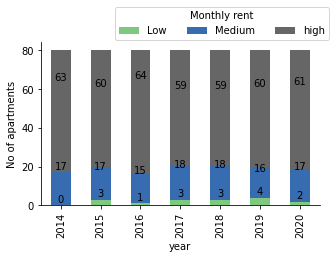

In [29]:
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_imputed.groupby("year")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,3), colormap = 'Accent', stacked= True)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels,title = 'Monthly rent', bbox_to_anchor =(1.05, 1.25), ncol = 3)
add_value_labels(a)
#plt.xlabel('Year')
plt.ylabel('No of apartments') 

plt.savefig("rentyearbar.png",bbox_inches = 'tight')
plt.show()


**Line Chart**

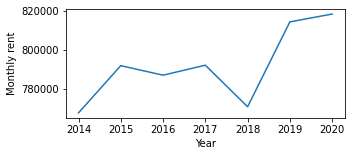

In [30]:
# Line chart
rent_year=data_imputed.groupby("year")["monthly rent"].sum().to_frame().reset_index()
plt.figure(figsize=(5,2))
plt.plot(rent_year["year"], rent_year["monthly rent"]) 
#Adding the aesthetics

plt.xlabel('Year')
plt.ylabel('Monthly rent') 
plt.savefig("rentyearline.png",bbox_inches = 'tight')
plt.show()

**Pie Diagram**

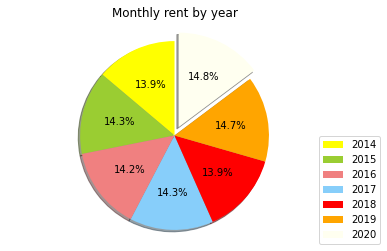

In [31]:
# Data to plot
labels = rent_year['year']
sizes = rent_year['monthly rent']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'orange', 'ivory']
explode = (0, 0, 0, 0, 0, 0, 0.1)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Monthly rent by year')
plt.axis('equal')
plt.savefig("rentyearpie.png",bbox_inches = 'tight')
plt.show()

### 2. `Rent by Apartment type`

**Bar plot**

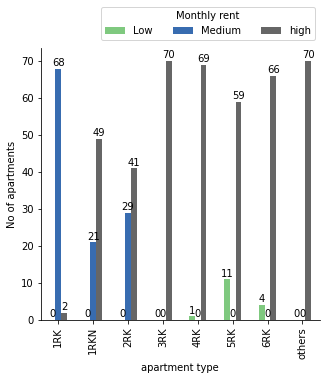

In [32]:
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_imputed.groupby("apartment type")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,5), colormap = 'Accent', stacked= False)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels, title = 'Monthly rent', bbox_to_anchor =(1,1.17),ncol = 3)
add_value_labels(a)
#plt.xlabel('Apartment type')
plt.ylabel('No of apartments')
plt.savefig("renttypebar.png",bbox_inches = 'tight')
plt.show()

**Line chart**

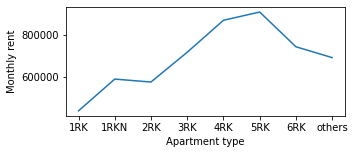

In [33]:
# Line chart
rent_apartment=data_imputed.groupby("apartment type")["monthly rent"].sum().to_frame().reset_index()
plt.figure(figsize=(5,2))
plt.plot(rent_apartment["apartment type"], rent_apartment["monthly rent"]) 
#Adding the aesthetics

plt.xlabel('Apartment type')
#commenting as it does not display in the plot
plt.ylabel('Monthly rent') 
plt.savefig("renttypeline.png",bbox_inches = 'tight')
plt.show()

**Pie Diagram**

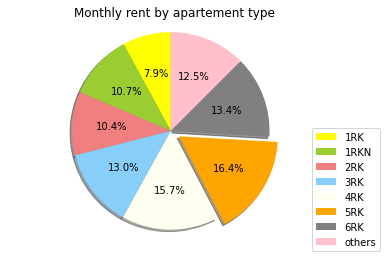

In [34]:
# Data to plot
labels = rent_apartment['apartment type']
sizes = rent_apartment['monthly rent']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'ivory', 'orange', 'grey', 'pink']
explode = (0, 0, 0, 0, 0, 0.1, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.axis('equal')
plt.savefig("renttypepie.png",bbox_inches = 'tight')
plt.title('Monthly rent by apartement type')
plt.show()

### 3. `Rent by Regions`

**Bar plot**

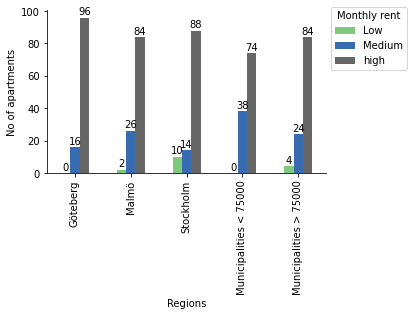

In [35]:
position=[0,1,2,3,4]
regions = ['Göteberg', 'Malmö', 'Stockholm', 'Municipalities < 75000', 'Municipalities > 75000']
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_imputed.groupby("location")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,3), colormap = 'Accent', stacked= False)

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels,title = 'Monthly rent', bbox_to_anchor =(1, 1.05), ncol = 1)
add_value_labels(a)
plt.xlabel('Regions')
plt.xticks(position, regions)
plt.ylabel('No of apartments')
plt.savefig("rentlocbar.png" ,bbox_inches = 'tight')
plt.show()

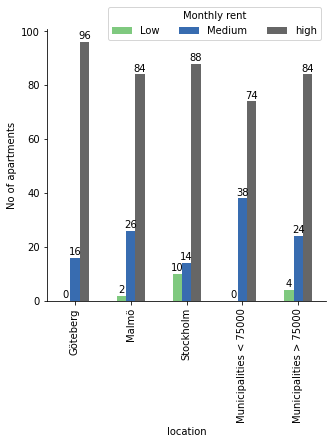

In [36]:
position=[0,1,2,3,4]
regions = ['Göteberg', 'Malmö', 'Stockholm', 'Municipalities < 75000', 'Municipalities > 75000']
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_imputed.groupby("location")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,5), colormap = 'Accent', stacked= False)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.xticks(position, regions)
add_value_labels(a)
plt.ylabel('No of apartments')
plt.legend(labels=ylabels,title = 'Monthly rent',bbox_to_anchor =(1.0001, 1.10), ncol = 3)
plt.show()

**Line chart**

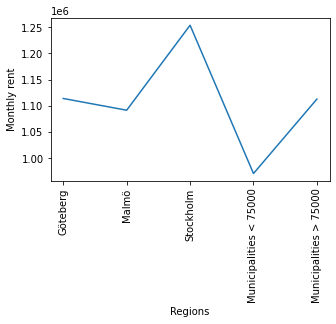

In [37]:
# Line chart
rent_location=data_imputed.groupby("location")["monthly rent"].sum().to_frame().reset_index()
plt.figure(figsize=(5,3))
plt.plot(rent_location["location"], rent_location["monthly rent"]) 
#Adding the aesthetics
#plt.title("Rent based on location")

g = [0, 1, 2, 3, 4]
labels = ['Göteberg', 'Malmö', 'Stockholm', 'Municipalities < 75000', 'Municipalities > 75000']

plt.xticks(g, labels, rotation='vertical')
plt.xlabel('Regions')
plt.ylabel('Monthly rent') 
plt.savefig("rentlocline.png",bbox_inches = 'tight')
plt.show()

**Pie Diagram**

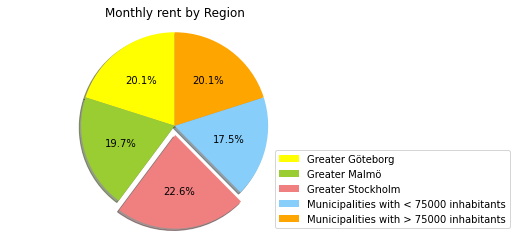

In [38]:
# Data to plot
labels = rent_location['location']
sizes = rent_location['monthly rent']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange']
explode = (0, 0, 0.1, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1.3,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.title('Monthly rent by Region')
plt.axis('equal')
plt.savefig("rentlocpie.png",bbox_inches = 'tight')
plt.show()


### 4. `Rent by Apartment Developer`

**Bar plot**

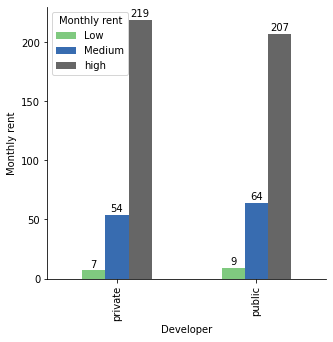

In [39]:
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_imputed.groupby("developer")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,5), colormap = 'Accent', stacked= False)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels, title = 'Monthly rent')
add_value_labels(a)
plt.xlabel('Developer')
plt.ylabel('Monthly rent')
plt.savefig("rentdevbar.png",bbox_inches = 'tight')
plt.show()

**Line chart**

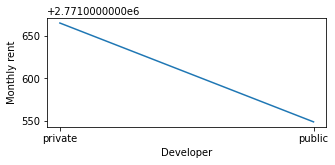

In [40]:
# Line chart
rent_developer=data_imputed.groupby("developer")["monthly rent"].sum().to_frame().reset_index()
plt.figure(figsize=(5,2))
plt.plot(rent_developer["developer"], rent_developer["monthly rent"]) 
#Adding the aesthetics
#plt.title('Rent based on apartment developer')
plt.xlabel('Developer')
plt.ylabel('Monthly rent') 
plt.savefig("rentdevline.png",bbox_inches = 'tight')
plt.show()

**Pie Diagram**

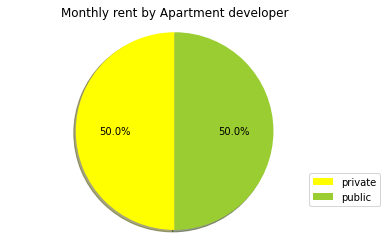

In [41]:
# Data to plot
labels = rent_developer['developer']
sizes = rent_developer['monthly rent']
colors = ['yellow', 'yellowgreen']
explode = (0, 0)

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.title('Monthly rent by Apartment developer')
plt.axis('equal')
plt.savefig("rentdevpie.png",bbox_inches = 'tight')
plt.show()

### 5. `Dwellings by year`

In [42]:
dwelling_year=data_imputed.groupby("year")["dwellings"].sum().to_frame().reset_index()

**Bar plot**

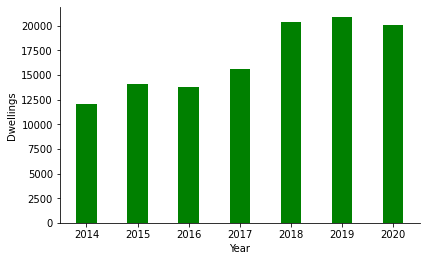

In [43]:
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_year["year"],dwelling_year["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Year")
plt.ylabel("Dwellings")
#plt.title("No. of apartments in each year")
plt.savefig("dwellyrbar.png" ,bbox_inches = 'tight')
plt.show()

#### **Line chart**

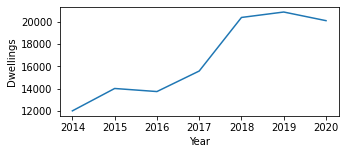

In [44]:
plt.figure(figsize=(5,2))
# Line chart
plt.plot(dwelling_year["year"], dwelling_year["dwellings"]) 
#Adding the aesthetics
#plt.title('Change in number of apartments by year')
plt.xlabel('Year')
plt.ylabel('Dwellings') 
plt.savefig("dwellyrline.png" ,bbox_inches = 'tight')
plt.show()

**Pie diagram**

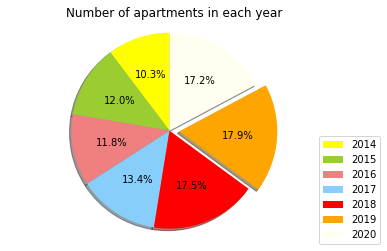

In [45]:
# Data to plot
labels = dwelling_year['year']
sizes = dwelling_year['dwellings']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'orange', 'ivory']
explode = (0, 0, 0, 0, 0, 0.1, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Number of apartments in each year')
plt.axis('equal')
plt.savefig("dwellyrpie.png",bbox_inches = 'tight')
plt.show()

### 6. `Dwellings by Location`

In [46]:
dwelling_location=data_imputed.groupby("location")["dwellings"].sum().to_frame().reset_index()

**Bar plot**

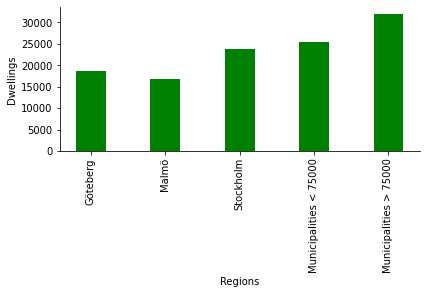

In [47]:
fig = plt.figure(figsize =(5, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_location["location"],dwelling_location["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

g = [0, 1, 2, 3, 4]
labels = ['Göteberg', 'Malmö', 'Stockholm', 'Municipalities < 75000', 'Municipalities > 75000']
plt.xticks(g, labels, rotation='vertical')

plt.xlabel('Regions')
plt.ylabel('Dwellings') 
plt.savefig("dwelllocbar.png" ,bbox_inches = 'tight')
plt.show()

**Line chart**

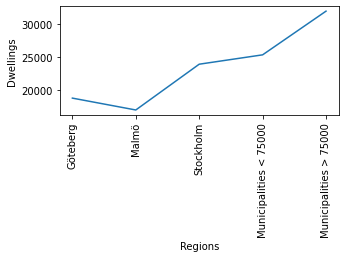

In [48]:
# Line chart
fig = plt.figure(figsize =(5, 2))
plt.plot(dwelling_location["location"], dwelling_location["dwellings"]) 
g = [0, 1, 2, 3, 4]
labels = ['Göteberg', 'Malmö', 'Stockholm', 'Municipalities < 75000', 'Municipalities > 75000']
plt.xticks(g, labels, rotation='vertical')

#Adding the aesthetics
#plt.title('Change in number of apartments by location')

plt.xlabel('Regions')
plt.ylabel('Dwellings') 
plt.savefig("dwelllocline.png" ,bbox_inches = 'tight')
#Show the plot
plt.show()

**Pie diagram**

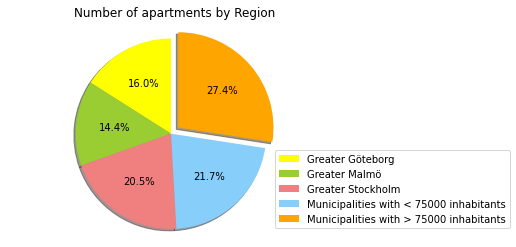

In [49]:
# Data to plot
labels = dwelling_location['location']
sizes = dwelling_location['dwellings']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange']
explode = (0, 0, 0, 0, 0.1)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1.3,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.title('Number of apartments by Region')
plt.axis('equal')
plt.savefig("dwelllocpie.png",bbox_inches = 'tight')
plt.show()

### 7. `Dwellings by Apartment type`

In [50]:
dwelling_type=data_imputed.groupby("apartment type")["dwellings"].sum().to_frame().reset_index()

**Bar plot**

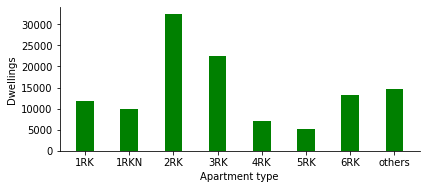

In [51]:
fig = plt.figure(figsize =(5, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_type["apartment type"],dwelling_type["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Apartment type")
plt.ylabel('Dwellings') 
plt.savefig("dwelltypebar.png" ,bbox_inches = 'tight')
plt.show()

**Line chart**

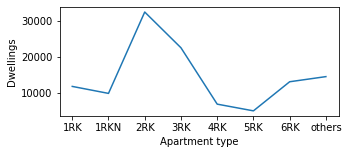

In [52]:
# Line chart
fig = plt.figure(figsize =(5, 2))
plt.plot(dwelling_type["apartment type"], dwelling_type["dwellings"]) 
labels = dwelling_type["apartment type"]
#Adding the aesthetics
plt.xlabel("Apartment type")
plt.ylabel('Dwellings') 
plt.savefig("dwelltypeline.png" ,bbox_inches = 'tight')
plt.show()

**Pie Diagram**

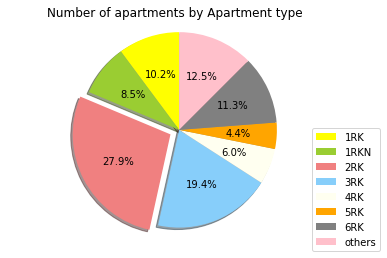

In [53]:
# Data to plot
labels = dwelling_type['apartment type']
sizes = dwelling_type['dwellings']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'ivory', 'orange', 'grey', 'pink']
explode = (0, 0, 0.1, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Number of apartments by Apartment type')
plt.axis('equal')

plt.savefig("dwelltypepie.png" ,bbox_inches = 'tight')
plt.show()

### 8. `Dwellings by Apartment developer`

In [54]:
dwelling_developer=data_imputed.groupby("developer")["dwellings"].sum().to_frame().reset_index()

**Bar plot**

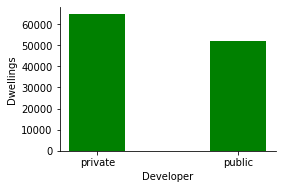

In [55]:
fig = plt.figure(figsize =(3, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_developer["developer"],dwelling_developer["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Developer")
plt.ylabel('Dwellings') 
#plt.title("Developer vs No. of apartments")
plt.savefig("dwelldevbar.png" ,bbox_inches = 'tight')
plt.show()

**Line Chart**

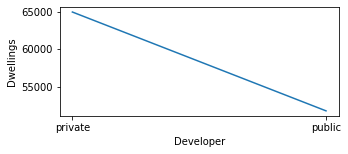

In [56]:
# Line chart
fig = plt.figure(figsize =(5, 2))
plt.plot(dwelling_developer["developer"], dwelling_developer["dwellings"]) 
labels = dwelling_developer["developer"]
#Adding the aesthetics
#plt.title('Change in number of apartments by type of developer')
plt.xlabel("Developer")
plt.ylabel('Dwellings') 
plt.savefig("dwelldevline.png" ,bbox_inches = 'tight')
plt.show()

**Pie Diagram**

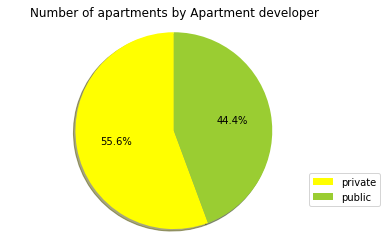

In [57]:
# Data to plot
labels = dwelling_developer['developer']
sizes = dwelling_developer['dwellings']
colors = ['yellow', 'yellowgreen']
explode = (0, 0)

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.title('Number of apartments by Apartment developer')
plt.axis('equal')
plt.savefig("dwelldevpie.png" ,bbox_inches = 'tight')
plt.show()

### **3b: Heat Maps.**

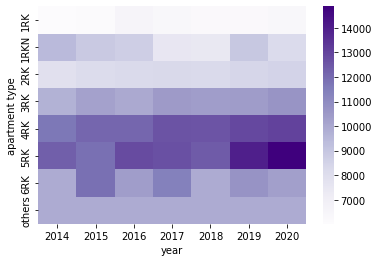

In [58]:
columns = ["year", "apartment type", "monthly rent"]
X = data_imputed[columns]
new = X.pivot_table(index='apartment type', columns='year', values='monthly rent', aggfunc='mean')
ax = plt.axes()
sns_plot = sns.heatmap(new, ax=ax,cmap='Purples')
sns_fig = sns_plot.get_figure()
sns_fig.savefig("heattypeyearrent.png",bbox_inches = 'tight')
#ax.set_title("The distribution of rent by apartment type for each year")

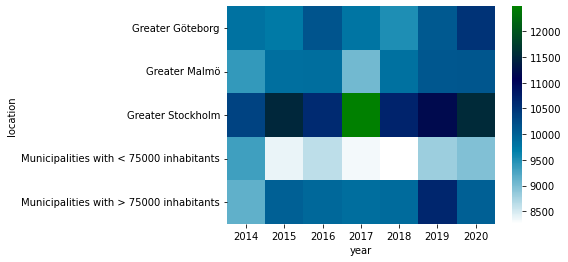

In [59]:
columns = ["year", "location", "monthly rent"]
X = data_imputed[columns]
new = X.pivot_table(index='location', columns='year', values='monthly rent', aggfunc='mean')
ax = plt.axes()
sns_plot = sns.heatmap(new, ax=ax, cmap='ocean_r')
sns_fig = sns_plot.get_figure()
sns_fig.savefig("heatlocyearrent.png",bbox_inches = 'tight')
#ax.set_title("The distribution of rent in different location for each year")

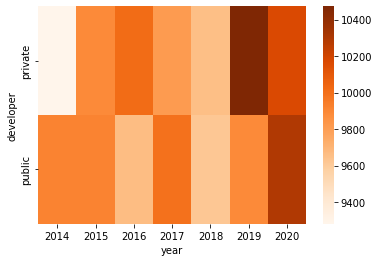

In [60]:
columns = ["year", "developer", "monthly rent"]
X = data_imputed[columns]
new = X.pivot_table(index='developer', columns='year', values='monthly rent', aggfunc='mean')
ax = plt.axes()
sns_plot = sns.heatmap(new, ax=ax, cmap='Oranges')
sns_fig = sns_plot.get_figure()
sns_fig.savefig("heatdevyearrent.png",bbox_inches = 'tight')
#ax.set_title("The distribution of rent by developer type for each year")

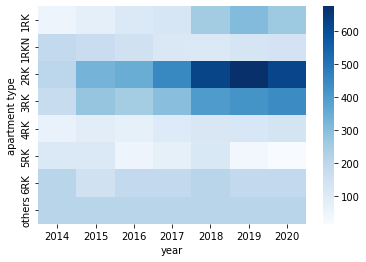

In [61]:
columns = ["year", "apartment type", "dwellings"]
X = data_imputed[columns]
new = X.pivot_table(index='apartment type', columns='year', values='dwellings', aggfunc='mean')
ax = plt.axes()
sns_plot = sns.heatmap(new, ax=ax, cmap='Blues')
sns_fig = sns_plot.get_figure()
sns_fig.savefig("heattypeyeardwel.png",bbox_inches = 'tight')
#ax.set_title("The number of different types of apartments in each year")

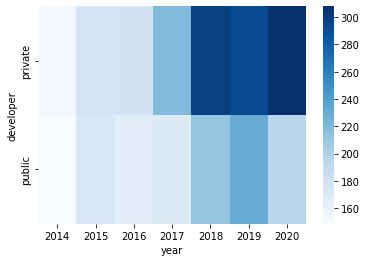

In [62]:
columns = ["year", "developer", "dwellings"]
X = data_imputed[columns]
new = X.pivot_table(index='developer', columns='year', values='dwellings', aggfunc='mean')
ax = plt.axes()
sns_plot = sns.heatmap(new, ax=ax, cmap='Blues')
sns_fig = sns_plot.get_figure()
sns_fig.savefig("heatdevyeardwel.png",bbox_inches = 'tight')
#ax.set_title("The number apartments built by different developer in each year")

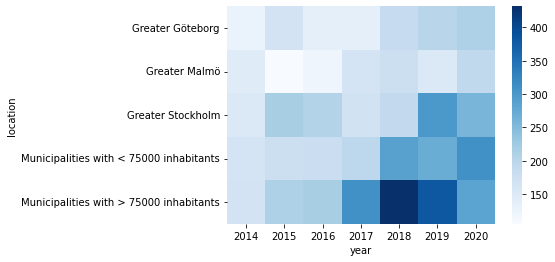

In [63]:
columns = ["year", "location", "dwellings"]
X = data_imputed[columns]
new = X.pivot_table(index='location', columns='year', values='dwellings', aggfunc='mean')
ax = plt.axes()

sns_plot = sns.heatmap(new, ax=ax, cmap='Blues')
sns_fig = sns_plot.get_figure()
sns_fig.savefig("heatlocyeardwel.png",bbox_inches = 'tight')
#ax.set_title("The number apartments built by different developer in each year")

### **3c: Scatter plots.**

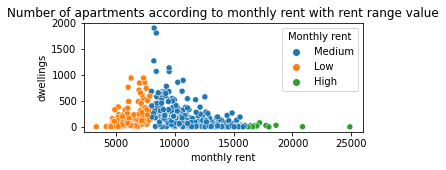

In [64]:
fig, ax = plt.subplots(figsize=(5,2))
sns.scatterplot(x=data_imputed["monthly rent"], y=data_imputed["dwellings"], hue=data_imputed['class label'], ax=ax)
plt.legend(title = 'Monthly rent', bbox_to_anchor =(1,1),ncol = 1)
plt.title('Number of apartments according to monthly rent with rent range value')
plt.show()

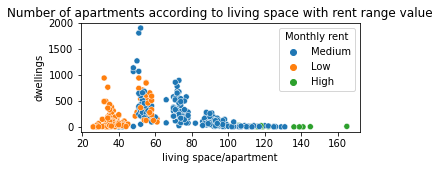

In [65]:
fig, ax = plt.subplots(figsize=(5,2))
sns.scatterplot(x=data_imputed["living space/apartment"], y=data_imputed["dwellings"], ax= ax, hue=data_imputed['class label'])
plt.legend(title = 'Monthly rent', bbox_to_anchor =(1,1),ncol = 1)
plt.title('Number of apartments according to living space with rent range value')
plt.show()

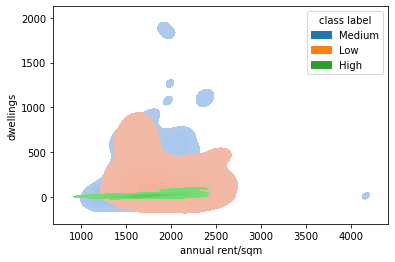

In [66]:
sns.kdeplot(x=data_imputed["annual rent/sqm"], y=data_imputed["dwellings"], hue=data_imputed['class label'], shade=True)
plt.show()

### **3d: Plotting the Principle components.**

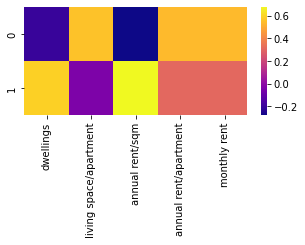

In [67]:
plt.figure(figsize=(5,2))
sns_plot = sns.heatmap(df_principal_components, cmap='plasma')    
sns_fig = sns_plot.get_figure()
sns_fig.savefig("dfprinci.png",bbox_inches = 'tight')

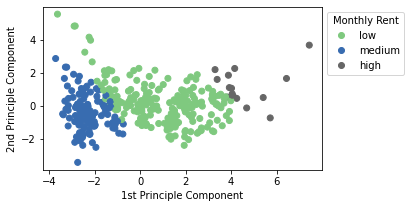

In [68]:
# Plot the three principal components with colors respective to the class.
new_label = pd.factorize(data_imputed['class label'])[0]
labels = ['low','medium','high']

plt.figure(figsize=(5,3))
scatter = plt.scatter(x=x_pca[:,0], y=x_pca[:,1], c=new_label, cmap = 'Accent')

#plt.title('Principle components 1 and 2')
plt.legend(handles=scatter.legend_elements()[0], 
           title="Monthly Rent",labels = labels, bbox_to_anchor =(1,1),ncol = 1)
plt.xlabel('1st Principle Component')
plt.ylabel('2nd Principle Component')
plt.savefig("pca.png",bbox_inches = 'tight')

<Figure size 400x160 with 0 Axes>

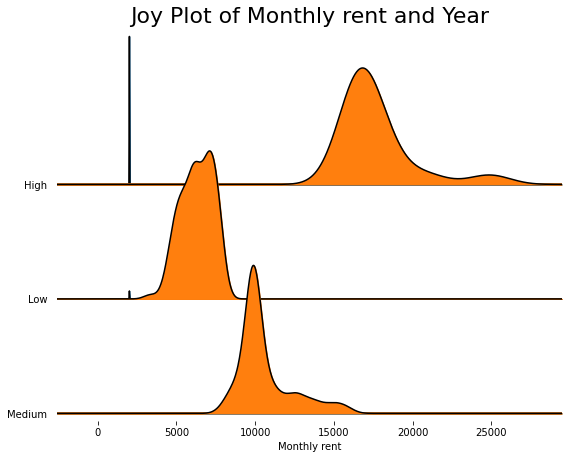

In [69]:
#Joy Plot
plt.figure(figsize=(5,2), dpi= 80)
fig, axes = jp.joyplot(data_imputed, column=['year', 'monthly rent'], by="class label", ylim='own', figsize=(8,6))

# Decoration
plt.title('Joy Plot of Monthly rent and Year', fontsize=22)
plt.xlabel('Monthly rent')
plt.show()

### **3e. Location wise plotting**

#### a. Stockholm

In [70]:
data_Stockholm = data_imputed.loc[data_imputed['location'] == 'Greater Stockholm']

In [71]:
data_Stockholm.head(2)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
0,Greater Stockholm,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
1,Greater Stockholm,public,1RK,190.00000,35.000000,2659.000000,91964.00000,7664,2020,Low


Scatter PLot

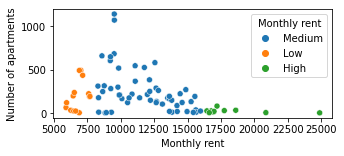

In [72]:
# Number of apartments according to monthly rent with rent range value in Stockholm region
fig, ax = plt.subplots(figsize=(5,2))
sns.scatterplot(x=data_Stockholm["monthly rent"], y=data_Stockholm["dwellings"], hue=data_Stockholm['class label'], ax=ax)
plt.legend(title = 'Monthly rent', bbox_to_anchor =(1,1),ncol = 1)

# plt.title('Number of apartments according to monthly rent with rent range value')
plt.ylabel('Number of apartments')
plt.xlabel('Monthly rent')
plt.savefig("scatterstm.png",bbox_inches = 'tight')
plt.show()

Bar plots

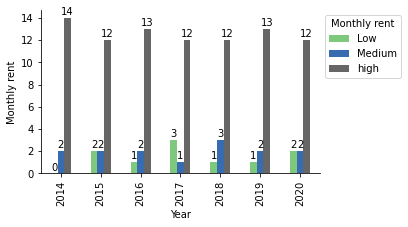

In [73]:
# Monthly rent in each year in Stockholm NOT USED
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_Stockholm.groupby("year")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,3), colormap = 'Accent', stacked= False)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels,title = 'Monthly rent', bbox_to_anchor =(1, 1), ncol = 1)
add_value_labels(a)
plt.xlabel('Year')
plt.ylabel('Monthly rent') 

#plt.savefig("rentyearbarStckhlm.png")
plt.show()

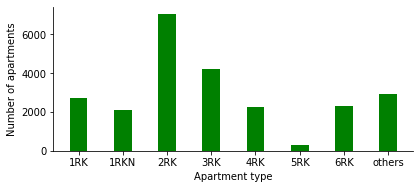

In [74]:
# Number of apartments according to monthly rent with rent range value in Stockholm region
dwelling_type_stckhlm = data_Stockholm.groupby("apartment type")["dwellings"].sum().to_frame().reset_index()

fig = plt.figure(figsize =(5, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_type_stckhlm["apartment type"],dwelling_type_stckhlm["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Apartment type")
plt.ylabel('Number of apartments') 
plt.savefig("barstm.png" ,bbox_inches = 'tight')
plt.show()

Pie Charts

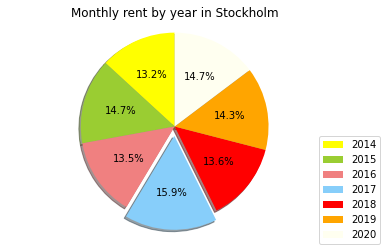

In [75]:
# Monthly rent by year in Stockholm

rent_yearStckhlm=data_Stockholm.groupby("year")["monthly rent"].sum().to_frame().reset_index()

labels = rent_yearStckhlm['year']
sizes = rent_yearStckhlm['monthly rent']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'orange', 'ivory']
explode = (0, 0, 0, 0.1, 0, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Monthly rent by year in Stockholm')
plt.axis('equal')
plt.savefig("piestm.png",bbox_inches = 'tight')
plt.show()

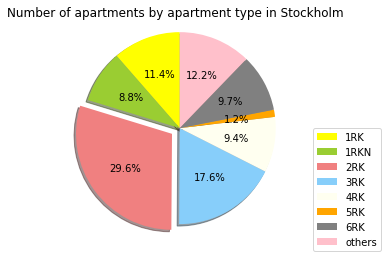

In [76]:
# Data to plot NOT USED
labels = dwelling_type_stckhlm['apartment type']
sizes = dwelling_type_stckhlm['dwellings']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'ivory', 'orange', 'grey', 'pink']
explode = (0, 0, 0.1, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Number of apartments by apartment type in Stockholm')
plt.axis('equal')

plt.savefig("dwelltypepieStckhlm.png" ,bbox_inches = 'tight')
plt.show()

#### b. Göteberg

In [77]:
data_Göteborg = data_imputed.loc[data_imputed['location'] == 'Greater Göteborg']

In [78]:
data_Göteborg.head(2)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
16,Greater Göteborg,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
17,Greater Göteborg,public,1RK,150.00000,39.000000,2082.000000,80934.00000,6745,2020,Low


Scatter Plot

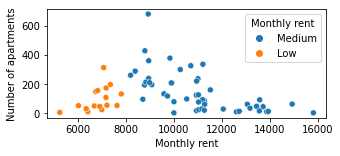

In [79]:
# Number of apartments according to monthly rent with rent range value in Göteborg region
fig, ax = plt.subplots(figsize=(5,2))
sns.scatterplot(x=data_Göteborg["monthly rent"], y=data_Göteborg["dwellings"], hue=data_Göteborg['class label'], ax=ax)
plt.legend(title = 'Monthly rent', bbox_to_anchor =(1,1),ncol = 1)
# plt.title('Number of apartments according to monthly rent with rent range value')
plt.ylabel('Number of apartments')
plt.xlabel('Monthly rent')
plt.savefig("scattergot.png" ,bbox_inches = 'tight')
plt.show()

Bar Plots

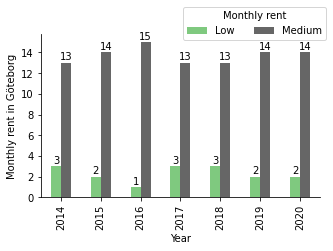

In [80]:
# Monthly rent in each year in Göteborg
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_Göteborg.groupby("year")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,3), colormap = 'Accent', stacked= False)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels,title='Monthly rent', bbox_to_anchor =(1.04, 1.2), ncol = 2)
add_value_labels(a)
plt.xlabel('Year')
plt.ylabel('Monthly rent in Göteborg') 

#plt.savefig("rentyearbarGöteborg.png")
plt.show()

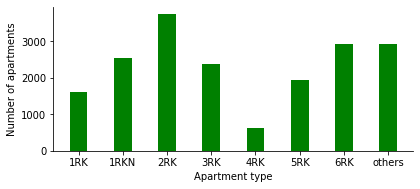

In [81]:
# Number of apartments according to monthly rent with rent range value in Göteborg region
dwelling_type_Göteborg = data_Göteborg.groupby("apartment type")["dwellings"].sum().to_frame().reset_index()

fig = plt.figure(figsize =(5, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_type_Göteborg["apartment type"],dwelling_type_Göteborg["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Apartment type")
plt.ylabel('Number of apartments') 
plt.savefig("bargot.png" ,bbox_inches = 'tight')
plt.show()

Pie Charts

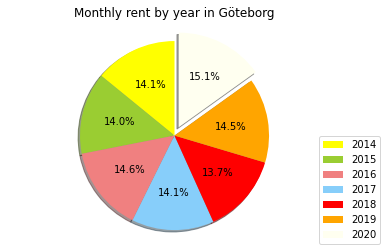

In [82]:
# Monthly rent by year in Göteborg

rent_yearGöteborg = data_Göteborg.groupby("year")["monthly rent"].sum().to_frame().reset_index()

labels = rent_yearGöteborg['year']
sizes = rent_yearGöteborg['monthly rent']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'orange', 'ivory']
explode = (0, 0, 0, 0, 0, 0, 0.1)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Monthly rent by year in Göteborg')
plt.axis('equal')
plt.savefig("piegot.png" ,bbox_inches = 'tight')
plt.show()

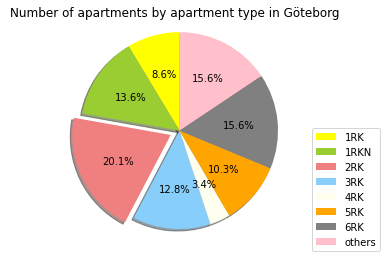

In [83]:
# Number of apartments by apartment type in Göteborg

labels = dwelling_type_Göteborg['apartment type']
sizes = dwelling_type_Göteborg['dwellings']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'ivory', 'orange', 'grey', 'pink']
explode = (0, 0, 0.1, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Number of apartments by apartment type in Göteborg')
plt.axis('equal')

plt.savefig("dwelltypepieGöteborg.png" ,bbox_inches = 'tight')
plt.show()

#### c. Malmö

In [84]:
data_Malmö= data_imputed.loc[data_imputed['location'] == 'Greater Malmö']

In [85]:
data_Malmö.head(2)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
32,Greater Malmö,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
33,Greater Malmö,public,1RK,128.00000,33.000000,2152.000000,70242.00000,5853,2020,Low


Scatter Plot

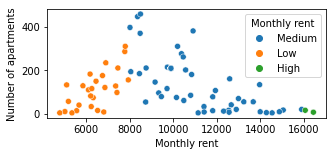

In [86]:
# Number of apartments according to monthly rent with rent range value in Göteborg region
fig, ax = plt.subplots(figsize=(5,2))
sns.scatterplot(x=data_Malmö["monthly rent"], y=data_Malmö["dwellings"], hue=data_Malmö['class label'], ax=ax)
# plt.title('Number of apartments according to monthly rent with rent range value')
plt.ylabel('Number of apartments')
plt.xlabel('Monthly rent')
plt.legend(title = 'Monthly rent', bbox_to_anchor =(1, 1), ncol = 1)
plt.savefig("scattermal.png" ,bbox_inches = 'tight')
plt.show()

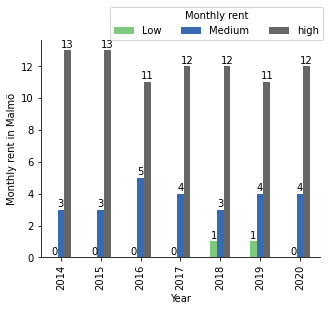

In [87]:
# Monthly rent in each year in Malmö
ylabels = ['Low', 'Medium', 'high']
rent_by_class = data_Malmö.groupby("year")['class label'].value_counts()
a = rent_by_class.unstack().plot(kind='bar', figsize=(5,4), colormap = 'Accent', stacked= False)
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.legend(labels=ylabels,title = 'Monthly rent', bbox_to_anchor =(1.03, 1.175), ncol = 3)
add_value_labels(a)
plt.xlabel('Year')
plt.ylabel('Monthly rent in Malmö') 

#plt.savefig("rentyearbarMalmö.png")
plt.show()

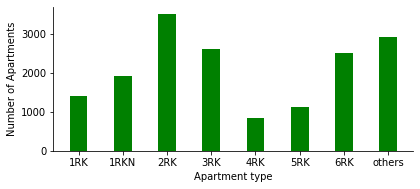

In [88]:
# Number of apartments according to monthly rent with rent range value in Malmö region
dwelling_type_Malmö = data_Malmö.groupby("apartment type")["dwellings"].sum().to_frame().reset_index()

fig = plt.figure(figsize =(5, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(dwelling_type_Malmö["apartment type"],dwelling_type_Malmö["dwellings"],width = 0.4, color='green')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Apartment type")
plt.ylabel('Number of Apartments') 
plt.savefig("barmal.png" ,bbox_inches = 'tight')
plt.show()

Pie Charts

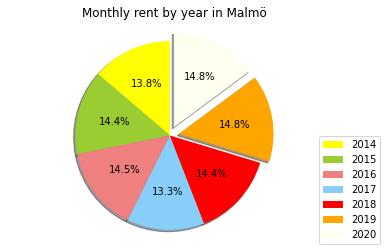

In [89]:
# Monthly rent by year in Malmö

rent_yearMalmö = data_Malmö.groupby("year")["monthly rent"].sum().to_frame().reset_index()

labels = rent_yearMalmö['year']
sizes = rent_yearMalmö['monthly rent']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'orange', 'ivory']
explode = (0, 0, 0, 0, 0, 0.1, 0.1)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Monthly rent by year in Malmö')
plt.axis('equal')
plt.savefig("piemal.png" ,bbox_inches = 'tight')
plt.show()

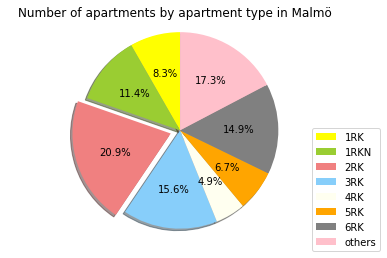

In [90]:
# Number of apartments by apartment type in Malmö

labels = dwelling_type_Malmö['apartment type']
sizes = dwelling_type_Malmö['dwellings']
colors = ['yellow', 'yellowgreen', 'lightcoral', 'lightskyblue', 'ivory', 'orange', 'grey', 'pink']
explode = (0, 0, 0.1, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
patches, percentage, text = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.legend(patches, labels, bbox_to_anchor=(1,0.3), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.title('Number of apartments by apartment type in Malmö')
plt.axis('equal')

plt.savefig("dwelltypepieMalmö.png" ,bbox_inches = 'tight')
plt.show()

### **3f. Summary plot**

In [91]:
data_imputed.head(2)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
0,Greater Stockholm,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
1,Greater Stockholm,public,1RK,190.00000,35.000000,2659.000000,91964.00000,7664,2020,Low


<Figure size 72x36 with 0 Axes>

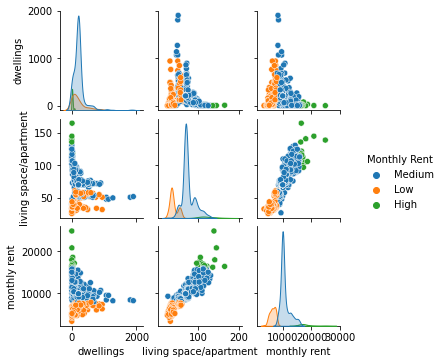

In [92]:
# Pair plot
plt.figure(figsize =(1, 0.5))
temp_data = data_imputed.copy()
temp_data.rename(columns = {'class label':'Monthly Rent'}, inplace = True)
sns.pairplot(temp_data[['dwellings', 'living space/apartment', 'monthly rent', 'Monthly Rent']], hue = 'Monthly Rent', height=1.7, diag_kind = 'kde')
plt.savefig("pairplot.png",bbox_inches = 'tight')

## **`Step 4: Prediction of the class label.`**

In [93]:
data_imputed.head(2)

,location,developer,apartment type,dwellings,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent,year,class label
0,Greater Stockholm,public,1RKN,208.51532,70.064067,1771.902507,118787.16156,9898,2020,Medium
1,Greater Stockholm,public,1RK,190.00000,35.000000,2659.000000,91964.00000,7664,2020,Low


In [94]:
dropcols = ['dwellings','year','class label']
X = data_imputed.drop(dropcols,axis=1)           
X.replace({'Greater Stockholm':4,'Greater Göteborg':5,'Greater Malmö':6,'Municipalities with > 75000 inhabitants':7,
'Municipalities with < 75000 inhabitants':8, 'public':9, 'private':10, '1RKN':11, '1RK':12, '2RK':13, '3RK':14, '4RK':15, 
'5RK':16, '6RK':17, 'others':18}, inplace=True)

In [95]:
y = pd.Series(data_imputed['class label'])

In [96]:
def switch_data(argument):
    switcher = {
       'Greater Stockholm':4,'Greater Göteborg':5,'Greater Malmö':6,'Municipalities with > 75000 inhabitants':7,
'Municipalities with < 75000 inhabitants':8, 'public':9, 'private':10, '1RKN':11, '1RK':12, '2RK':13, '3RK':14, '4RK':15, 
'5RK':16, '6RK':17, 'others':18
    }
    return switcher[argument]

In [97]:
colnames = X.columns
colnames = colnames.values

#data received from the user in the form of a list of items
data_to_classify = ['Greater Stockholm','public', '1RK','72','1500','112000','9000']

for i in range(3):
    k=data_to_classify[i]
    r=switch_data(k)
    data_to_classify[i] = r

sample = pd.DataFrame(data = [data_to_classify], columns = colnames)
sample

,location,developer,apartment type,living space/apartment,annual rent/sqm,annual rent/apartment,monthly rent
0,4,9,12,72,1500,112000,9000


In [98]:
# create svc and fit it to the test data
svc = SVC(kernel = 'poly')
svc.fit(X, y)
svc_predicted = svc.predict(sample)

In [99]:
#predicted class label for monthly rent range
svc_predicted 

array(['Medium'], dtype=object)